# Policy Briefing Title that Matches PDF Title

## CASA0013: Foundations of Spatial Data Science

### Student Ids: ucfther, ucftYYYY, etc.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

Font set up

In [238]:
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
bfont = {'fontname':'Liberation Sans Narrow', 'weight':'normal', 'horizontalalignment':'left'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

# Read in data

### caching set up

In [2]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

### Boundary data

In [3]:
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

# need to change this to ward level for analysis
msoas = gpd.read_file( cache_data('http://orca.casa.ucl.ac.uk/~jreades/data/MSOA-2011.gpkg', ddir) )
msoas = msoas.to_crs(epsg=27700)

print("Done.")

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Found data/geo/MSOA-2011.gpkg locally!
Done.


In [4]:
msoas.columns.tolist()[:5]

['MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD']

<AxesSubplot:>

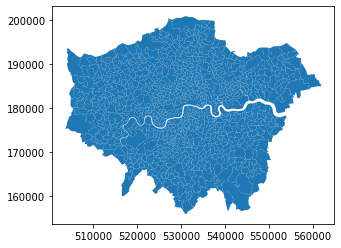

In [240]:
msoas.plot()

### Airbnb data

In [273]:
# Set download URL
host = 'https://orca.casa.ucl.ac.uk'
path = '~jreades/data/2022-09-10-listings.csv.gz'
url  = f'{host}/{path}'

df = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")


Data frame is 69,351 x 75


In [7]:
print(df.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

In [8]:
df.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20220910194334,2022-09-11,city scrape,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,4.93,4.75,4.82,NaN,f,2,1,1,0,0.20
1,15400,https://www.airbnb.com/rooms/15400,20220910194334,2022-09-11,city scrape,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,...,4.82,4.93,4.73,NaN,f,1,1,0,0,0.57
2,284532,https://www.airbnb.com/rooms/284532,20220910194334,2022-09-11,city scrape,COSY STUDIO-FLAT WITH A GREAT VIEW,My very RECENTLY RENOVATED flat is located in ...,Shoreditch is simply the coolest area in London!,https://a0.muscache.com/pictures/2932872/00037...,1481412,...,4.86,4.72,4.31,NaN,f,1,1,0,0,0.34
3,106332,https://www.airbnb.com/rooms/106332,20220910194334,2022-09-11,city scrape,"Lovely large room, Bethnal Green",Lovely characterful room in a house belonging ...,NaN,https://a0.muscache.com/pictures/82437180/20b7...,264345,...,4.93,4.92,4.83,NaN,f,1,0,1,0,0.47
4,17402,https://www.airbnb.com/rooms/17402,20220910194334,2022-09-11,city scrape,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,...,4.69,4.88,4.59,NaN,f,5,5,0,0,0.36


In [274]:
path = os.path.join('data','raw') # A default location to save raw data
fn   = url.split('/')[-1]         # What does this do?
print(f"Writing to: {fn}")

Writing to: 2022-09-10-listings.csv.gz


In [275]:
if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
df.to_csv(os.path.join(path,fn), index=False)
print("Done.")

Done.


# Data Cleaning

In [276]:
cols = ['id', 'listing_url', 'last_scraped', 'name', 'host_id', 'host_name', 'host_since', 'host_location', 
 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 
 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 
 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm', 
 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_365', 'calendar_last_scraped', 
 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review']

In [278]:
testing = False

if testing:
    df = pd.read_csv(os.path.join(path,fn), 
                low_memory=False, usecols=cols, nrows=10000)
else:
    df = pd.read_csv(os.path.join(path,fn), 
                low_memory=False, usecols=cols)

print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 69,358 x 39


In [13]:
df.sample(3)

,id,listing_url,last_scraped,name,host_id,host_name,host_since,host_location,host_response_time,host_is_superhost,...,calendar_updated,has_availability,availability_30,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review
6252,"7,513,990.00",https://www.airbnb.com/rooms/7513990,2022-09-11,Large room in centre of Fulham,"27,729,413.00",Shaun,2015-02-14,"Market Harborough, United Kingdom",NaN,f,...,NaN,t,0.00,0.00,2022-09-11,0.00,0.00,0.00,NaN,NaN
4684,"6,182,640.00",https://www.airbnb.com/rooms/6182640,2022-09-11,Lovely Room in a Great Flat!,"16,257,394.00",Jaz,2014-06-01,"London, United Kingdom",NaN,f,...,NaN,t,0.00,0.00,2022-09-11,1.00,0.00,0.00,2015-05-08,2015-05-08
1731,"1,954,732.00",https://www.airbnb.com/rooms/1954732,2022-09-11,Hackney Terrace House,"5,110,004.00",Benedetta,2013-02-16,"London, United Kingdom",NaN,f,...,NaN,t,0.00,0.00,2022-09-11,9.00,0.00,0.00,2014-07-16,2020-01-04


drop NAs by rows

In [279]:
df.drop(df[df.id.isna()].index.array, axis=0, inplace=True)

drop Nulls by columns

In [280]:
df.isnull().sum(axis=0).sort_values(ascending=False)[:12]

bathrooms                       69354
calendar_updated                69353
neighbourhood_group_cleansed    69351
host_response_time              26530
host_neighbourhood              25759
last_review                     16787
first_review                    16785
host_location                   12369
bedrooms                         3435
beds                             1207
host_is_superhost                  26
name                               21
dtype: int64

In [281]:
df.drop(columns=['neighbourhood_group_cleansed','bathrooms','calendar_updated','host_response_time'], inplace=True)

drop Nulls by rows

In [282]:
df.isnull().sum(axis=1).sort_values(ascending=False).head(20)

66384    27
52563    27
23112    27
53487    27
64775    27
63388    27
9103     27
64776     9
6959      8
7415      8
4511      8
6365      8
45987     8
66385     8
5697      8
42838     7
46090     7
43976     6
42706     6
43318     6
dtype: int64

<class 'pandas.core.series.Series'>


<AxesSubplot:ylabel='Frequency'>

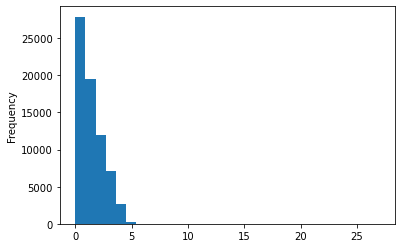

In [283]:
probs = df.isnull().sum(axis=1)
print(type(probs))       # Note that this has returned a series!
probs.plot.hist(bins=30)

In [284]:
df.drop(probs[probs > 4].index, inplace=True)

In [285]:
print(f"Have reduced data frame to: {df.shape[0]} rows and {df.shape[1]} columns")

Have reduced data frame to: 69150 rows and 35 columns


correct data type

In [286]:
bools = ['host_is_superhost','has_availability']

In [287]:
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace({'f':False, 't':True}).astype('bool')

Converting host_is_superhost
Converting has_availability


In [288]:
dates = ['last_scraped','host_since','calendar_last_scraped','first_review','last_review']

In [289]:
for d in dates:
    print("Converting " + d)
    df = df[df[d].str.match(r'\d{4}-\d{2}-\d{2}', na=True)] # Drop some non-date values
    df[d] = pd.to_datetime(df[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


In [290]:
cats = ['property_type','room_type']

In [291]:
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')

Converting property_type
Converting room_type


In [292]:
money = ['price']

In [293]:
for m in money:
    print(f"Converting {m}")
    df[m] = df[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


In [294]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','bedrooms','minimum_nights','maximum_nights','minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
         'availability_30','availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d']

In [295]:
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
Converting host_total_listings_count
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting bedrooms
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting minimum_nights_avg_ntm
  - !!!Converting to unsigned 16-bit integer!!!


TypeError: cannot safely cast non-equivalent float64 to uint16

In [296]:
df.beds.isna().value_counts()

False    68042
True      1107
Name: beds, dtype: int64

In [297]:
df.bedrooms.isna().value_counts()

False    65857
True      3292
Name: bedrooms, dtype: int64

In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69149 entries, 0 to 69357
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         69149 non-null  int64         
 1   listing_url                69149 non-null  object        
 2   last_scraped               69149 non-null  datetime64[ns]
 3   name                       69128 non-null  object        
 4   host_id                    69149 non-null  int64         
 5   host_name                  69149 non-null  object        
 6   host_since                 69149 non-null  datetime64[ns]
 7   host_location              56958 non-null  object        
 8   host_is_superhost          69149 non-null  bool          
 9   host_neighbourhood         43579 non-null  object        
 10  host_listings_count        69149 non-null  int64         
 11  host_total_listings_count  69149 non-null  int64         
 12  neig

In [299]:
df.drop(columns=['beds','bedrooms','calendar_last_scraped'], inplace=True)

save the cleaned listing file locally 

In [300]:
print(fn)

2022-09-10-listings.csv.gz


In [301]:
path = os.path.join('data','clean')

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
df.to_csv(os.path.join(path,fn.replace('.csv','-testing.csv' if testing else '.csv')), index=False)
print("Done.")

Done.


In [302]:
df.reset_index().to_feather(os.path.join(path,fn.replace('.csv.gz','-testing.feather' if testing else '.feather')))

In [303]:
df2 = pd.read_feather('data/clean/2022-09-10-listings.feather')
print(f"Data frame is {df2.shape[0]:,} x {df2.shape[1]}")

Data frame is 69,149 x 33


lat/long to geoseries

In [304]:
gdf = gpd.GeoDataFrame(df2, 
      geometry=gpd.points_from_xy(df2.longitude, df2.latitude, crs='epsg:4326'))

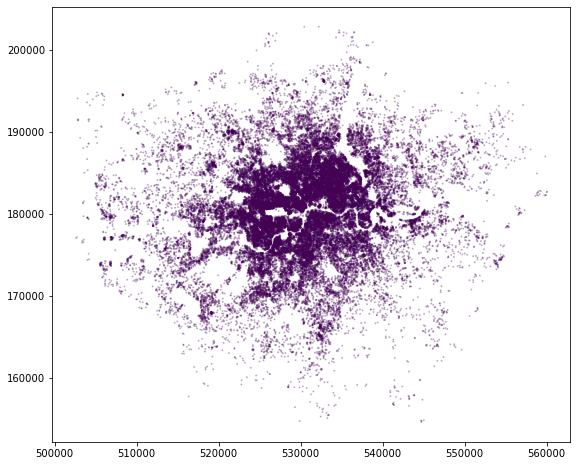

In [305]:
gdf.to_crs('epsg:27700').plot(column='number_of_reviews_l30d', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

In [56]:
import fiona; fiona.supported_drivers # But GeoPandas also directly supports feather and parquet

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

In [309]:
fn = '2022-09-10-listings.feather'
print(f"Using '{fn}' as basis for saving data...")
gdf.to_feather(os.path.join('data','geo',fn.replace('.feather','.geofeather')))

Using '2022-09-10-listings.feather' as basis for saving data...


### Join listing to boundary

In [310]:
listings = gpd.read_feather('data/geo/2022-09-10-listings.geofeather')
listings = listings.to_crs(epsg=27700)
listings = listings.drop(columns=['index']).set_index('id')
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Data frame is 69,149 x 32


In [311]:
msoa_listings = gpd.sjoin(listings, msoas.drop(
                        columns=['MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM',
                                 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 
                                 'AVHHOLDSZ']), predicate='within').drop(
                        columns=['latitude','longitude','index_right']
                )

In [312]:
msoa_listings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 68394 entries, 13913 to 663811353105819136
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   listing_url                68394 non-null  object        
 1   last_scraped               68394 non-null  datetime64[ns]
 2   name                       68373 non-null  object        
 3   host_id                    68394 non-null  int64         
 4   host_name                  68394 non-null  object        
 5   host_since                 68394 non-null  datetime64[ns]
 6   host_location              56371 non-null  object        
 7   host_is_superhost          68394 non-null  bool          
 8   host_neighbourhood         43440 non-null  object        
 9   host_listings_count        68394 non-null  int64         
 10  host_total_listings_count  68394 non-null  int64         
 11  neighbourhood_cleansed     68394 non-null 

In [313]:
msoa_listings.last_review.head(10)

id
13913     2022-07-15
89870     2022-08-28
958304    2013-12-29
993428    2022-08-20
1211331   2022-04-03
1458193   2022-09-10
2173226   2018-11-25
2053193   2018-11-26
2111026   2015-09-25
2558495   2016-11-16
Name: last_review, dtype: datetime64[ns]

select the recently reviewed listings in 2022

In [314]:
msoa_listings_2022 = msoa_listings[msoa_listings['last_review'].dt.strftime('%Y') == '2022']

In [315]:
msoa_listings_2022.last_review.count()

29342

This reduces the number of listings to 29342 from around 68394. Hence, around half of the listings are not active recently. 

# The Occupancy Model

Estimated booking per listing = number of review * 2

Occupancy (number of night booked) = Average length of stay * estimated booking per listing per year

The number of review is total throughout the lifetime of each listing. This is less useful for comparison as listings have different start and end dates on Airbnb. Since our analysis is based on 2022, it is more reasonable to use number of reviews in the last 30 days or last 12 months for analysis.  

It is found that the average length of stay for oversea tourists in London in 2019 is 5.47 nights. 
This group is the potential target renters for Airbnb. 
However, the data is in 2019, which could be influenced by the pandemic. It would be more accurate to obtain data from 2022. 
source: https://www.statista.com/statistics/487772/average-length-overseas-visits-by-purpose-london-uk/

However, it is also suggested that when the number of minimum nights bookable is larger than the average length of stay, the minimum nights would be used for calculation. 

Thus, occupancy could be calculated as

5.47 * (number of reviews in last 12 months) * 2

or

(minimum nights) * (number of reviews in last 12 months) * 2

In [326]:
msoa_listings_2022['averstay'] = np.where(msoa_listings_2022['minimum_nights']>5.47, msoa_listings_2022['minimum_nights'], 5.47)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [318]:
msoa_listings_2022['occupancy'] = msoa_listings_2022['averstay'] * msoa_listings_2022['number_of_reviews_ltm'] *2

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [319]:
msoa_listings_2022.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 29342 entries, 13913 to 663811353105819136
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   listing_url                29342 non-null  object        
 1   last_scraped               29342 non-null  datetime64[ns]
 2   name                       29342 non-null  object        
 3   host_id                    29342 non-null  int64         
 4   host_name                  29342 non-null  object        
 5   host_since                 29342 non-null  datetime64[ns]
 6   host_location              23806 non-null  object        
 7   host_is_superhost          29342 non-null  bool          
 8   host_neighbourhood         17315 non-null  object        
 9   host_listings_count        29342 non-null  int64         
 10  host_total_listings_count  29342 non-null  int64         
 11  neighbourhood_cleansed     29342 non-null 

In [121]:
msoa_listings_2022 = msoa_listings_2022.drop(columns = {'averstay'}, axis = 1)

In [320]:
msoa_listings_2022.averstay.head(10)

id
13913      5.47
89870      5.47
993428     5.47
1211331    5.47
1458193    5.47
13809624   5.47
15523209   5.47
15697845   5.47
18893833   5.47
21063433   5.47
Name: averstay, dtype: float64

In [321]:
msoa_listings_2022.occupancy.head(10)

id
13913       98.46
89870      262.56
993428     185.98
1211331     43.76
1458193     10.94
13809624   153.16
15523209   590.76
15697845   371.96
18893833    32.82
21063433   634.52
Name: occupancy, dtype: float64

In [322]:
msoa_listings_2022.minimum_nights.head(10)

id
13913       1
89870       1
993428      1
1211331     2
1458193     2
13809624    2
15523209    2
15697845    2
18893833    3
21063433    1
Name: minimum_nights, dtype: int64

In [354]:
msoa_listings_2022.number_of_reviews_ltm.head(10)

id
13913       9.00
89870      24.00
993428     17.00
1211331     4.00
1458193     1.00
13809624   14.00
15523209   54.00
15697845   34.00
18893833    3.00
21063433   58.00
Name: number_of_reviews_ltm, dtype: float64

In [353]:
msoa_listings_2022.availability_365.head(10)

id
13913      343.00
89870      343.00
993428     221.00
1211331    314.00
1458193     59.00
13809624   321.00
15523209    41.00
15697845   322.00
18893833     0.00
21063433   315.00
Name: availability_365, dtype: float64

In [352]:
msoa_listings_2022.availability_365.describe()

count   29,342.00
mean       158.36
std        129.78
min          0.00
25%         32.00
50%        135.00
75%        293.00
max        365.00
Name: availability_365, dtype: float64

<AxesSubplot:ylabel='Frequency'>

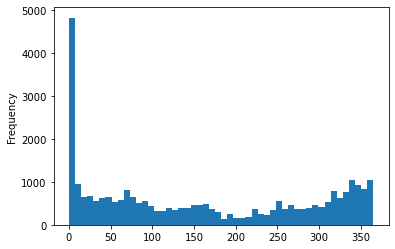

In [327]:
msoa_listings_2022.availability_365.plot.hist(bins=50) # histogram

In [328]:
msoa_listings_2022.occupancy.describe()

count   29,342.00
mean       135.11
std        262.70
min         10.94
25%         32.82
50%         76.58
75%        153.16
max     13,870.00
Name: occupancy, dtype: float64

<AxesSubplot:ylabel='Frequency'>

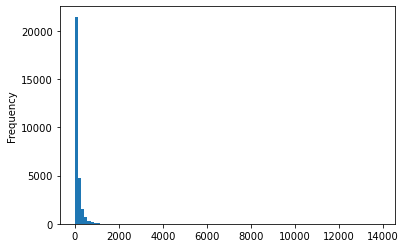

In [329]:
msoa_listings_2022.occupancy.plot.hist(bins=100) # histogram

In [330]:
msoa_listings_2022.sort_values(by = 'occupancy',ascending=False).head(20)[['name','price','minimum_nights','minimum_nights_avg_ntm','number_of_reviews_ltm','occupancy']]

,name,price,minimum_nights,minimum_nights_avg_ntm,number_of_reviews_ltm,occupancy
id,,,,,,
45373006,DOUBLE STUDIO @ CRAVEN HILL GARDENS,159.00,365,148.40,19.00,"13,870.00"
24020480,Double room with The Shard view in Kennington SE5,29.00,360,360.00,18.00,"12,960.00"
46810060,DOUBLE ROOM @ CRAVEN HILL GARDENS,145.00,365,148.40,14.00,"10,220.00"
7742194,Cosy Double studio in Zone 2 Hammersmith (8),45.00,170,8.60,24.00,"8,160.00"
47408549,Double Room+ Ensuite,167.00,1,1.00,660.00,"7,220.40"
30760930,Double Garden View room - London House Hotel***,343.00,1,1.10,631.00,"6,903.14"
43120947,Private double room with en suite facilities,110.00,1,1.00,615.00,"6,728.10"
24507428,Jack's place - Luxury Industrial style 1 bed flat,128.00,90,90.00,36.00,"6,480.00"
4594609,£100 for entire 2 bed flat in trendy east London!,74.00,120,120.00,27.00,"6,480.00"


The extremely high occupancy above 365 nights per year indicates errors in the estimation method. 
When comparing columns minimum_nights and minimum_nights_avg_ntm, it is found  that the later could be more accurate in representing the shortest booking length, which might vary during the year controlled by the owners. 

In [331]:
msoa_listings_2022['averstay2'] = np.where(msoa_listings_2022['minimum_nights_avg_ntm']>5.47, msoa_listings_2022['minimum_nights_avg_ntm'], 5.47)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [332]:
msoa_listings_2022['occupancy2'] = msoa_listings_2022['averstay2'] * msoa_listings_2022['number_of_reviews_ltm'] *2

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [333]:
msoa_listings_2022.occupancy2.describe()

count   29,342.00
mean       179.11
std        521.46
min         10.94
25%         32.82
50%         76.58
75%        182.00
max     66,864.80
Name: occupancy2, dtype: float64

In [358]:
msoa_listings_2022.sort_values(by = 'occupancy2',ascending=False).head(20)[['name','price','minimum_nights_avg_ntm','number_of_reviews_ltm','occupancy2']]

,name,price,minimum_nights_avg_ntm,number_of_reviews_ltm,occupancy2
id,,,,,
19962547,Stunning & Modern 3-Bed Home In Victoria,591.00,879.80,38.00,"66,864.80"
24020480,Double room with The Shard view in Kennington SE5,29.00,360.00,18.00,"12,960.00"
52804602,"Chinatown-Soho-Piccadilly, Two Bedroom Flat for 4",499.00,170.00,36.00,"12,240.00"
52954343,Marylebone Mews - Beautiful 2 bedroom flat,243.00,90.00,65.00,"11,700.00"
27960111,"Great Location, Bright & Clean, Covent Garden ...",425.00,155.00,26.00,"8,060.00"
47408549,Double Room+ Ensuite,167.00,1.00,660.00,"7,220.40"
30760930,Double Garden View room - London House Hotel***,343.00,1.10,631.00,"6,903.14"
43120947,Private double room with en suite facilities,110.00,1.00,615.00,"6,728.10"
4594609,£100 for entire 2 bed flat in trendy east London!,74.00,120.00,27.00,"6,480.00"


There are still some high values. The minimum length of stay higher than 90 nights may breach the short-term rental regulation. 

Listings that are highly occupied (occupancy>365) could be owing to high review rate or high minimum nights. Those that are frequently reviewed and obtaining high minimun nights might be less possible. Some high minimum nights might be typo from the host. Others might be that the host would like to increase the exposure of their listings but not renting them out on Airbnb platfrom, but on their own website, so the hosts set the minimum nights on purpose. Apart from those, listing with high minimum nights may breach the regulation of STR minimum night of 90 nights. Thus, those listings may bias the analysis on occupancy and they'll be removed from the dataset. However, analysis from other scopes like STR regulations on minimum nights could use the data. 

In [355]:
to_drop = msoa_listings_2022[(msoa_listings_2022.minimum_nights_avg_ntm > 90) | 
            (msoa_listings_2022.minimum_nights_avg_ntm*msoa_listings_2022.number_of_reviews_ltm > 365)]
to_drop.occupancy3.count()


1005

In [357]:
msoa_listings_2022[(msoa_listings_2022.occupancy2 > 365)].occupancy2.count()

3367

In [360]:
to_drop.head(10)[['number_of_reviews_ltm','averstay2','occupancy2','minimum_nights_avg_ntm']]

,number_of_reviews_ltm,averstay2,occupancy2,minimum_nights_avg_ntm
id,,,,
17329226,23.00,29.20,"1,343.20",29.20
53356158,18.00,29.00,"1,044.00",29.00
521982,19.00,28.50,"1,083.00",28.50
7771180,14.00,30.50,854.00,30.50
22175503,28.00,27.80,"1,556.80",27.80
44458852,18.00,27.80,"1,000.80",27.80
434962,27.00,30.60,"1,652.40",30.60
5988788,21.00,96.80,"4,065.60",96.80
7527534,26.00,75.30,"3,915.60",75.30


1005 out of 3367 are most unlikely cases. 

In [361]:
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

<AxesSubplot:>

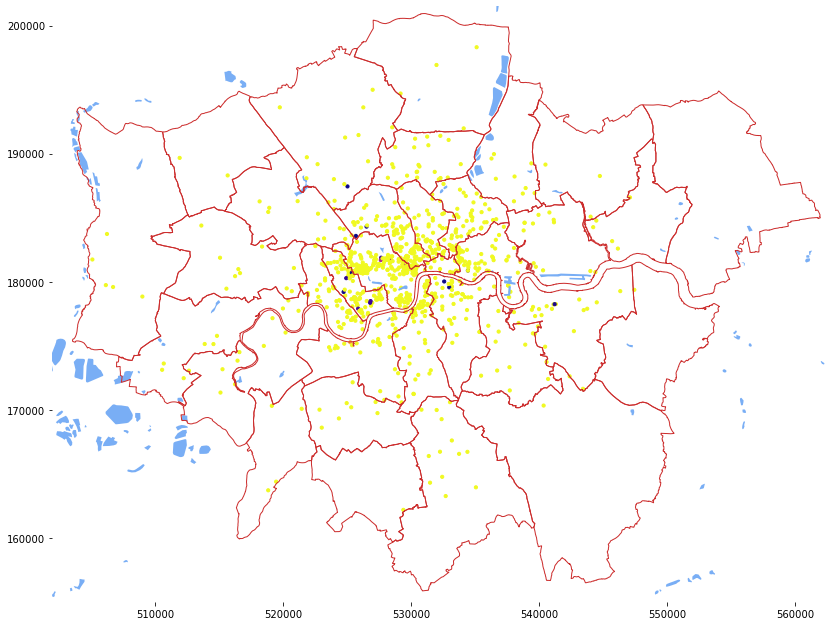

In [362]:
f,ax = plt_ldn(water, boros)
to_drop.plot(column='occupancy3', markersize=10, alpha=1, cmap='plasma', ax=ax)

For occupancy over 365, occupancy would be set as 365, which is the maximum reasonable value per year. 

In [363]:
msoa_listings_2022_cleaned = msoa_listings_2022.drop(index=to_drop.index)
print(f"Cleaned data has {msoa_listings_2022_cleaned.shape[0]:,} rows.")

Cleaned data has 28,337 rows.


In [366]:
msoa_listings_2022_cleaned['occupancy3'] = np.where(msoa_listings_2022_cleaned['occupancy2']>365, 365, msoa_listings_2022_cleaned['occupancy2'])
msoa_listings_2022_cleaned.occupancy3.describe()


count   28,337.00
mean       116.02
std        110.28
min         10.94
25%         32.82
50%         76.58
75%        164.10
max        365.00
Name: occupancy3, dtype: float64

<AxesSubplot:ylabel='Frequency'>

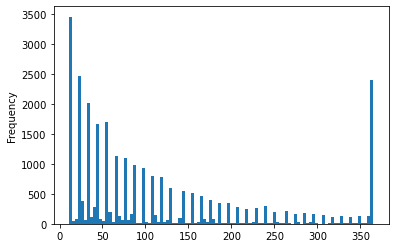

In [365]:
msoa_listings_2022_cleaned.occupancy3.plot.hist(bins=100) # histogram

### Note: this result above is different from the result on the Inside Airbnb website. Too many listings that are fully occupied..

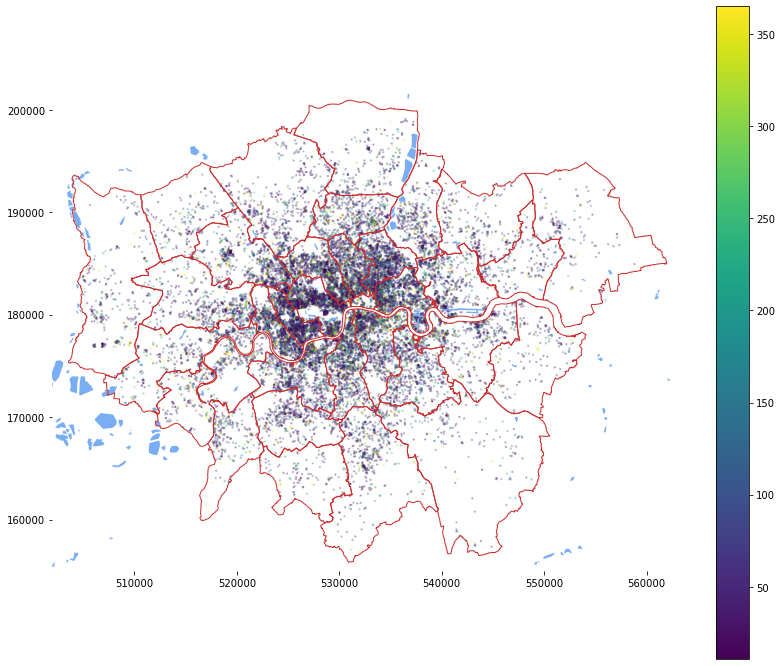

In [367]:
f,ax = plt_ldn(water, boros)
msoa_listings_2022_cleaned.plot(column='occupancy3', cmap='viridis', alpha=0.25, markersize=2, figsize=(12,8),legend=True,ax=ax);

In [368]:
msoa_listings_2022_cleaned.describe()[['occupancy3','availability_365']]

,occupancy3,availability_365
count,"28,337.00","28,337.00"
mean,116.02,157.75
std,110.28,130.03
min,10.94,0.00
25%,32.82,31.00
50%,76.58,134.00
75%,164.10,293.00
max,365.00,365.00


since the result is highly skewed. Median would be used to determine high and low values.  The availability of the lisitng in the future 365 days as per the calender. The listing may be not available because it is booked by a guest or blocked by the host. The higher the Occupancy and the higher the availability, the higher the intensity of renting activity. But it is also possible that the availability is underestimated since the guests may pre-booked thier stay. 

In [375]:
occumid = msoa_listings_2022_cleaned.occupancy3.median()
availmid = msoa_listings_2022_cleaned.availability_365.median()
msoa_listings_HH = msoa_listings_2022_cleaned[(msoa_listings_2022_cleaned.occupancy3 >= occumid) & (msoa_listings_2022_cleaned.availability_365 >= availmid)]

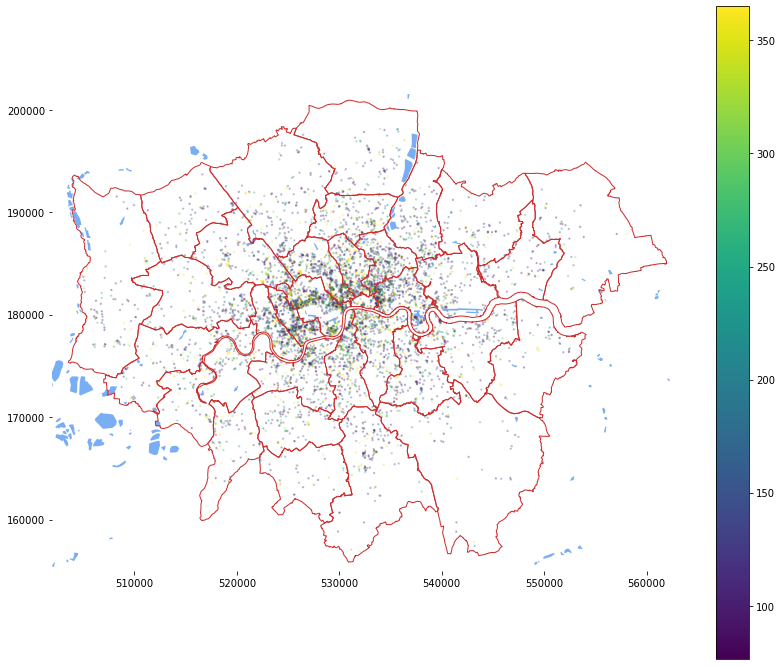

In [376]:
f,ax = plt_ldn(water, boros)
msoa_listings_HH.plot(column='occupancy3', cmap='viridis', alpha=0.25, markersize=2, figsize=(12,8),legend=True,ax=ax);

In [377]:
msoa_listings_2022_cleaned['quar'] = np.where((msoa_listings_2022_cleaned.occupancy3 >= occumid) & (msoa_listings_2022_cleaned.availability_365 >= availmid), 'HH',
                                             (np.where((msoa_listings_2022_cleaned.occupancy3 >= occumid) & (msoa_listings_2022_cleaned.availability_365 < availmid), 'HL',
                                             (np.where((msoa_listings_2022_cleaned.occupancy3 < occumid) & (msoa_listings_2022_cleaned.availability_365 < availmid), 'LL', 
                                                     'LH')))))

In [378]:
msoa_listings_2022_cleaned.head(10)[['quar','occupancy3','availability_365']]

,quar,occupancy3,availability_365
id,,,
13913,HH,98.46,343.00
89870,HH,262.56,343.00
993428,HH,185.98,221.00
1211331,LH,43.76,314.00
1458193,LL,10.94,59.00
13809624,HH,153.16,321.00
15523209,HL,365.00,41.00
15697845,HH,365.00,322.00
18893833,LL,32.82,0.00


In [379]:
cats2 = ['quar']
for c in cats2:
    print(f"Converting {c}")
    msoa_listings_2022_cleaned[c] = msoa_listings_2022_cleaned[c].astype('category')

Converting quar


In [380]:
print(msoa_listings_2022_cleaned[cats2[0]].cat.categories.values)

['HH' 'HL' 'LH' 'LL']


group by msoas

In [381]:
test = msoa_listings_2022_cleaned.groupby(
                ['MSOA11CD']).listing_url.agg(Count='count')
test.head(3)

,Count
MSOA11CD,
E02000001,210
E02000002,2
E02000003,6


In [382]:
pivot = msoa_listings_2022_cleaned.groupby(
                ['MSOA11CD','quar']
        ).listing_url.agg(Count='count').reset_index().pivot(
                index='MSOA11CD', columns=['quar'], values=['Count'])
pivot.head(3)

Count            
quar         HH  HL  LH  LL
MSOA11CD                   
E02000001   104  36  46  24
E02000002     1   0   1   0
E02000003     1   1   4   0

In [383]:
pivot.sum()

       quar
Count  HH      7244
       HL      7134
       LH      6937
       LL      7022
dtype: int64

In [384]:
print(msoa_listings_2022_cleaned[msoa_listings_2022_cleaned.quar=='HH'].listing_url.count()) # to check 

7244


In [385]:
pivot.columns = ['HH','HL','LH','LL']

In [386]:
quar = pd.merge(msoas.set_index('MSOA11CD'), pivot, left_index=True, right_index=True)

In [387]:
quar.head()

,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,HH,HL,LH,LL
MSOA11CD,,,,,,,,,,,,,,,,
E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.50,4385,1.60,"MULTIPOLYGON (((531667.624 180534.992, 531647....",104,36,46,24
E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.30,2713,2.50,"MULTIPOLYGON (((548881.563 190845.265, 548881....",1,0,1,0
E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.90,3834,2.60,"MULTIPOLYGON (((549102.438 189324.625, 548954....",1,1,4,0
E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.80,2318,2.60,"MULTIPOLYGON (((551549.998 187364.637, 551478....",2,0,1,0
E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.10,3183,2.70,"MULTIPOLYGON (((549099.634 187656.076, 549161....",3,0,3,1


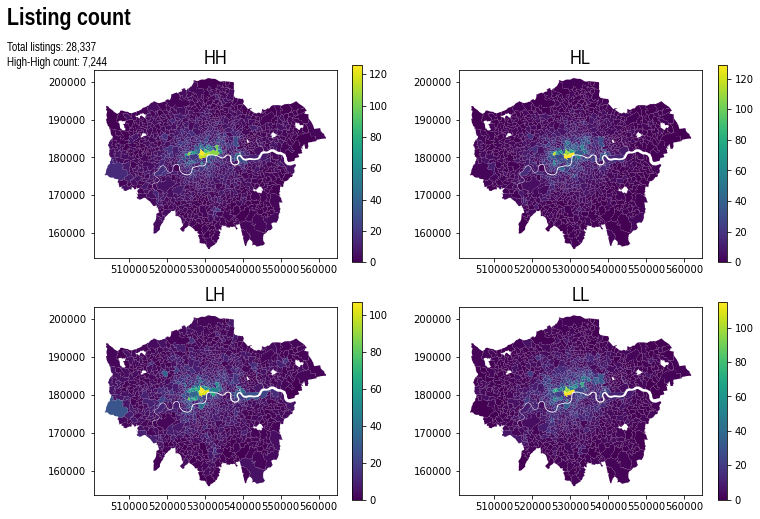

In [400]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar.plot(column='HH', ax=axes[0,0], legend=True, cmap='viridis')
axes[0,0].set_title('HH', size=20, **afont)

quar.plot(column='HL', ax=axes[0,1], legend=True, cmap='viridis')
axes[0,1].set_title('HL', size=20, **afont)

quar.plot(column='LH', ax=axes[1,0], legend=True, cmap='viridis')
axes[1,0].set_title('LH', size=20, **afont)

quar.plot(column='LL', ax=axes[1,1], legend=True, cmap='viridis')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Listing count', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {test['Count'].sum():,.0f}\nHigh-High count: {quar['HH'].sum():,.0f}", **bfont);

Text(0.025, 0.98, 'Usual residents per MSOAs')

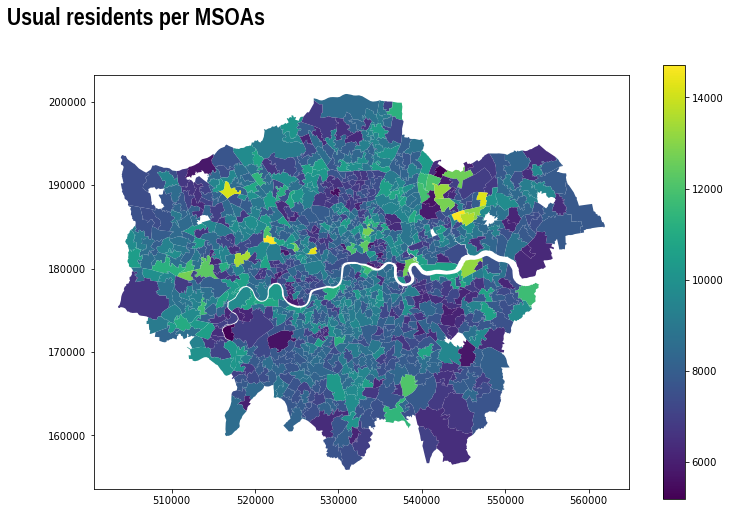

In [420]:
f,ax = plt.subplots(1,1,figsize=(12,8))

quar.plot(column='USUALRES', ax=ax, legend=True, cmap='viridis')
f.suptitle('Usual residents per MSOAs', x=0.025, ha='left', size=24, **tfont)


This result shows large range of the listing count but MSOAs with the high counts are rare as the purple colour has high coverage. High counts concentrate around inner London, where the number of usual residents is slightly lower. 

In [390]:
pts  = PowerTransformer()

pivot_norm = pd.DataFrame(index=pivot.index)
for c in pivot.columns.to_list():
    pivot_norm[c] = pts.fit_transform(pivot[c].to_numpy().reshape(-1,1))#power transform

pivot_norm.head()

,HH,HL,LH,LL
MSOA11CD,,,,
E02000001,2.81,1.79,2.27,1.53
E02000002,-0.98,-1.56,-1.09,-1.54
E02000003,-0.98,-0.77,-0.02,-1.54
E02000004,-0.53,-1.56,-1.09,-1.54
E02000005,-0.22,-1.56,-0.28,-0.81


In [391]:
quar_norm = pd.merge(msoas.set_index('MSOA11CD'), pivot_norm, left_index=True, right_index=True)

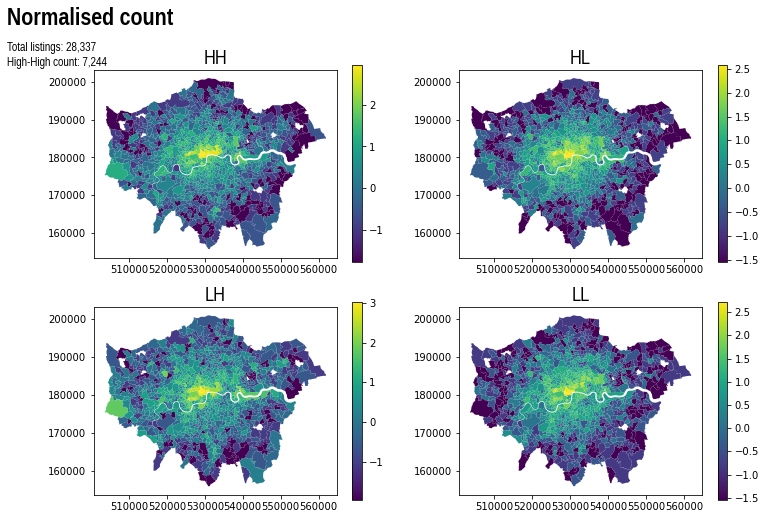

In [402]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar_norm.plot(column='HH', ax=axes[0,0], legend=True, cmap='viridis')
axes[0,0].set_title('HH', size=20, **afont)

quar_norm.plot(column='HL', ax=axes[0,1], legend=True, cmap='viridis')
axes[0,1].set_title('HL', size=20, **afont)

quar_norm.plot(column='LH', ax=axes[1,0], legend=True, cmap='viridis')
axes[1,0].set_title('LH', size=20, **afont)

quar_norm.plot(column='LL', ax=axes[1,1], legend=True, cmap='viridis')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Normalised count', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {test['Count'].sum():,.0f}\nHigh-High count: {quar['HH'].sum():,.0f}", **bfont);

From the outputs, the high occupancy and high availability listings are concentrated in inner London MSOAs, where the total listings are high overall. 

In [405]:
print(quar.columns.to_list())

['MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'geometry', 'HH', 'HL', 'LH', 'LL']


In [409]:
quar_density = quar.drop(columns = ['LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ'], axis =1)

In [411]:
quar_density['count'] = quar_density.loc[:,['HH','HL','LH','LL']].sum(axis=1)
quar_density.head()

,MSOA11NM,USUALRES,geometry,HH,HL,LH,LL,count
MSOA11CD,,,,,,,,
E02000001,City of London 001,7375,"MULTIPOLYGON (((531667.624 180534.992, 531647....",104,36,46,24,210
E02000002,Barking and Dagenham 001,6775,"MULTIPOLYGON (((548881.563 190845.265, 548881....",1,0,1,0,2
E02000003,Barking and Dagenham 002,10045,"MULTIPOLYGON (((549102.438 189324.625, 548954....",1,1,4,0,6
E02000004,Barking and Dagenham 003,6182,"MULTIPOLYGON (((551549.998 187364.637, 551478....",2,0,1,0,3
E02000005,Barking and Dagenham 004,8562,"MULTIPOLYGON (((549099.634 187656.076, 549161....",3,0,3,1,7


In [414]:
quar_density['HHper'] = quar_density['HH'] / quar_density['count']
quar_density['HLper'] = quar_density['HL'] / quar_density['count']
quar_density['LHper'] = quar_density['LH'] / quar_density['count']
quar_density['LLper'] = quar_density['LL'] / quar_density['count']

quar_density.head()

,MSOA11NM,USUALRES,geometry,HH,HL,LH,LL,count,HHper,HLper,LHper,LLper
MSOA11CD,,,,,,,,,,,,
E02000001,City of London 001,7375,"MULTIPOLYGON (((531667.624 180534.992, 531647....",104,36,46,24,210,0.50,0.17,0.22,0.11
E02000002,Barking and Dagenham 001,6775,"MULTIPOLYGON (((548881.563 190845.265, 548881....",1,0,1,0,2,0.50,0.00,0.50,0.00
E02000003,Barking and Dagenham 002,10045,"MULTIPOLYGON (((549102.438 189324.625, 548954....",1,1,4,0,6,0.17,0.17,0.67,0.00
E02000004,Barking and Dagenham 003,6182,"MULTIPOLYGON (((551549.998 187364.637, 551478....",2,0,1,0,3,0.67,0.00,0.33,0.00
E02000005,Barking and Dagenham 004,8562,"MULTIPOLYGON (((549099.634 187656.076, 549161....",3,0,3,1,7,0.43,0.00,0.43,0.14


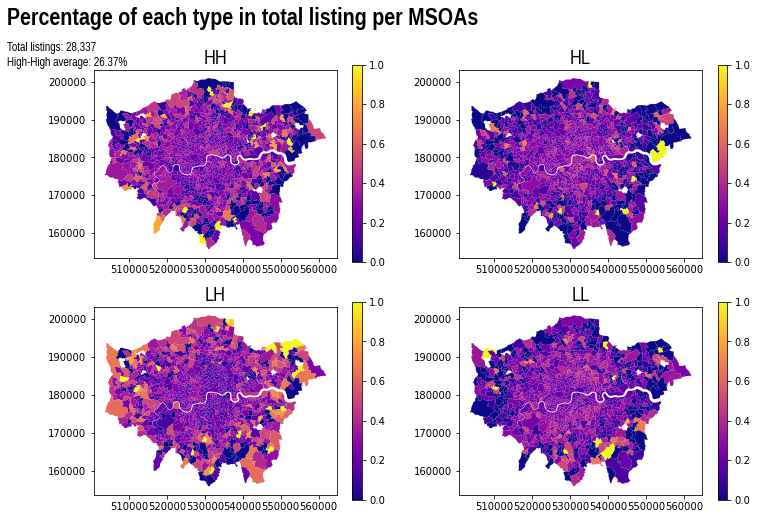

In [423]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar_density.plot(column='HHper', ax=axes[0,0], legend=True, cmap='plasma')
axes[0,0].set_title('HH', size=20, **afont)

quar_density.plot(column='HLper', ax=axes[0,1], legend=True, cmap='plasma')
axes[0,1].set_title('HL', size=20, **afont)

quar_density.plot(column='LHper', ax=axes[1,0], legend=True, cmap='plasma')
axes[1,0].set_title('LH', size=20, **afont)

quar_density.plot(column='LLper', ax=axes[1,1], legend=True, cmap='plasma')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Percentage of each type in total listing per MSOAs', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {quar_density['count'].sum():,.0f}\nHigh-High average: {quar_density['HHper'].mean()*100:,.2f}%", **bfont);

This result shows that the high counts of listings in inner London are mostly highly occupied and available when comparing to other 3 maps.  However, those 4 different types in inner London MSOAs are largely equal ratio. 

Outer London has higher proportion of low occupancy high availability listings, indicating low intensity as tourists' choice for stay. 